In [1]:
from data_loader import DataLoaderECHR
data_path= "/users/eleves-b/2021/andrei.barbu/ECHR_Dataset/"
df_dict  = DataLoaderECHR(data_path + "EN_train", data_path + "EN_dev", data_path + "EN_test").load_data()

In [3]:
df_train = df_dict['train']
df_train['n_sentences'] = df_train['TEXT'].apply(len)

<AxesSubplot:>

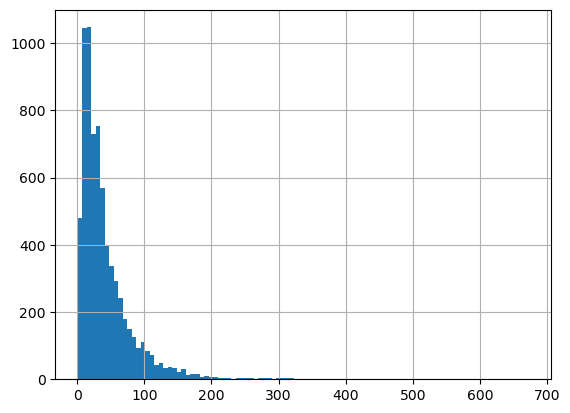

In [4]:
df_train['n_sentences'].hist(bins=100)

In [ ]:
df_dict["train"].head()

,ITEMID,LANGUAGEISOCODE,RESPONDENT,BRANCH,DATE,DOCNAME,IMPORTANCE,CONCLUSION,JUDGES,TEXT,VIOLATED_ARTICLES,VIOLATED_PARAGRAPHS,VIOLATED_BULLETPOINTS,NON_VIOLATED_ARTICLES,NON_VIOLATED_PARAGRAPHS,NON_VIOLATED_BULLETPOINTS,VIOLATED,n_sentences
0,001-100005,ENG,TUR,ADMISSIBILITY,2010,SHAMSI v. TURKEY,4,Inadmissible,Françoise Tulkens;Ireneu Cabral Barreto;Kristi...,"[The applicant, Mr Maher Muhilddin Gazel Al Sh...",[],[],[],[],[],[],0,8
1,001-100024,ENG,ARM,CHAMBER,2010,CASE OF HOVHANNISYAN AND SHIROYAN v. ARMENIA,3,Reminder inadmissible;Violation of P1-1;Just s...,Alvina Gyulumyan;Elisabet Fura;Ineta Ziemele;J...,"[4. The applicants were born in 1976, 1973 and...",[],[],[],[],[],[],0,25
2,001-100026,ENG,ARM,CHAMBER,2010,CASE OF YERANOSYAN AND OTHERS v. ARMENIA,4,Violation of P1-1,Alvina Gyulumyan;Elisabet Fura;Ineta Ziemele;J...,"[4. The applicants were born in 1976, 1975, 19...",[],[],[],[],[],[],0,15
3,001-100029,ENG,RUS,CHAMBER,2010,CASE OF AKHMATKHANOVY v. RUSSIA,4,Violation of Art. 2 (substantive aspect);Viola...,Anatoly Kovler;Christos Rozakis;Dean Spielmann...,"[4. The applicants are:, 1) Ms Bilat Akhmatkha...","[13, 2, 3, 5]",[],[],[],[],[],1,123
4,001-100038,ENG,NLD,CHAMBER,2010,CASE OF A. v. THE NETHERLANDS,3,Violation of Art. 3 (in case of expulsion to L...,Alvina Gyulumyan;Corneliu Bîrsan;Egbert Myjer;...,[7. The applicant was born in 1972 and lives i...,[3],[],[],[13],[],[],1,224


In [5]:
import torch
import torch.nn as nn
import math
from transformers import AutoModel

class BertClassifier(nn.Module):
    def __init__(self, 
                 freeze_bert=False, 
                 use_lora=False, 
                 lora_rank=4,
                 use_attention=False,
                 max_sentences=128,
                 dropout_rate=0.1,
                 modelname   = "google/bert_uncased_L-2_H-128_A-2"
                 ):
        """
        Parameters:
         - freeze_bert: If True, freeze BERT parameters (unless using LoRA).
         - use_lora: If True, apply a LoRA adapter to BERT's linear layers.
         - lora_rank: The rank for low-rank adaptation in LoRA.
         - use_attention: If True, use a hierarchical attention head over sentence embeddings.
                          Otherwise, use an MLP head that concatenates sentence embeddings.
         - max_sentences: Fixed number of sentences per document (with padding/truncation).
         - dropout_rate: Dropout rate in the classification head.
        """
        super(BertClassifier, self).__init__()
        # Load the pre-trained BERT model.
        self.bert = AutoModel.from_pretrained(modelname)
        print("Loaded BERT model:", modelname)
        self.hidden_size = self.bert.config.hidden_size
        self.use_attention = use_attention
        self.max_sentences = max_sentences

        # Apply LoRA modifications if requested.
        if use_lora:
            apply_lora(self.bert, lora_rank)
        elif freeze_bert:
            # Freeze all BERT parameters if not using LoRA.
            for param in self.bert.parameters():
                param.requires_grad = False

        self.dropout = nn.Dropout(dropout_rate)
        self.tanh = nn.Tanh()
        
        if use_attention:
            # For the hierarchical attention mechanism, we compute explicit query, key, and value.
            # The keys and values are computed from each sentence embedding.
            self.key_layer = nn.Linear(self.hidden_size, self.hidden_size)    # Projection for keys
            self.value_layer = nn.Linear(self.hidden_size, self.hidden_size)  # Projection for values
            # A learned context vector (used as the query) that is shared across sentences.
            # This is analogous to a fixed query vector in attention mechanisms.
            self.context_vector = nn.Parameter(torch.randn(self.hidden_size))
            # After attention, we pass the aggregated representation through a dense layer.
            self.dense_tanh = nn.Linear(self.hidden_size, self.hidden_size)
            self.classifier = nn.Linear(self.hidden_size, 2)
        else:
            # MLP-based head: concatenate sentence embeddings into a single vector.
            self.dense_tanh = nn.Linear(max_sentences * self.hidden_size, max_sentences * self.hidden_size)
            self.classifier = nn.Linear(max_sentences * self.hidden_size, 2)
            
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):
        """
        Forward pass for processing a batch of documents.
        Each document is represented as a list of sentences.
        
        Parameters:
         - input_ids: Tensor of shape (batch_size, max_sentences, seq_length)
         - attention_mask: Tensor of shape (batch_size, max_sentences, seq_length)
        """
        batch_size, num_sentences, seq_length = input_ids.size()
        # Flatten the sentences so BERT processes each sentence independently.
        input_ids_flat = input_ids.view(-1, seq_length)
        attention_mask_flat = attention_mask.view(-1, seq_length)
        
        # Obtain BERT sentence embeddings (using the pooled [CLS] token representation).
        outputs = self.bert(input_ids=input_ids_flat, attention_mask=attention_mask_flat)
        pooled_output = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs[1]
        # Reshape back to (batch_size, num_sentences, hidden_size).
        sentence_embeddings = pooled_output.view(batch_size, num_sentences, self.hidden_size)
        
        if self.use_attention:
            # ----------------------
            # Hierarchical Attention:
            # ----------------------
            # 1. Compute Keys (K) from sentence embeddings.
            #    Each sentence embedding is projected to obtain its key representation.
            K = self.key_layer(sentence_embeddings)  # shape: (batch_size, num_sentences, hidden_size)
            
            # 2. Compute Values (V) from sentence embeddings.
            #    Here, the values are also derived from the sentence embeddings.
            V = self.value_layer(sentence_embeddings)  # shape: (batch_size, num_sentences, hidden_size)
            
            # 3. Use a learned context vector as the Query (Q).
            #    Expand the context vector to match the batch size and add a sequence length dimension.
            #    Q shape: (batch_size, 1, hidden_size)
            Q = self.context_vector.unsqueeze(0).expand(batch_size, -1).unsqueeze(1)
            
            # 4. Compute scaled dot-product attention scores:
            #    scores = (Q * K^T) / sqrt(d_k)
            #    Here, K^T means transposing the last two dimensions of K.
            scores = torch.matmul(Q, K.transpose(-2, -1))  # shape: (batch_size, 1, num_sentences)
            scores = scores / math.sqrt(self.hidden_size)     # scale by sqrt(d_k)
            scores = scores.squeeze(1)                         # shape: (batch_size, num_sentences)
            
            # 5. Create a sentence mask to avoid attending to padded sentences.
            #    A sentence is considered valid if its attention_mask has a nonzero sum.
            sentence_mask = (attention_mask.sum(dim=2) > 0).float()  # shape: (batch_size, num_sentences)
            # Set scores of padded sentences to a very low value.
            scores = scores.masked_fill(sentence_mask == 0, -1e9)
            
            # 6. Apply softmax to obtain attention weights.
            attn_weights = torch.softmax(scores, dim=1)          # shape: (batch_size, num_sentences)
            attn_weights = attn_weights.unsqueeze(-1)            # shape: (batch_size, num_sentences, 1)
            
            # 7. Compute the context vector (document embedding) as the weighted sum of the values.
            doc_embedding = torch.sum(V * attn_weights, dim=1)     # shape: (batch_size, hidden_size)
            
            # Pass the aggregated representation through a dense layer.
            x = self.dropout(doc_embedding)
            x = self.dense_tanh(x)
        else:
            # ---------------------------
            # MLP-based head (non-attention):
            # ---------------------------
            # Concatenate sentence embeddings into a single vector.
            doc_embedding = sentence_embeddings.view(batch_size, -1)  # shape: (batch_size, max_sentences*hidden_size)
            x = self.dropout(doc_embedding)
            x = self.dense_tanh(x)
            
        # Apply non-linearity and dropout.
        x = self.tanh(x)
        x = self.dropout(x)
        # Final classification layer.
        logits = self.classifier(x)
        # Convert logits to probabilities.
        probs = self.softmax(logits)
        return probs

# Helper function for applying LoRA to a module's linear layers.
def apply_lora(module, lora_rank):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear):
            setattr(module, name, LoRALinear(child, lora_rank))
        else:
            apply_lora(child, lora_rank)

# A simple LoRA wrapper for a linear layer.
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, lora_rank=4, scaling=1.0):
        super(LoRALinear, self).__init__()
        self.linear = linear_layer
        self.lora_rank = lora_rank
        self.scaling = scaling
        # Create low-rank adaptation matrices.
        self.lora_A = nn.Parameter(torch.zeros(lora_rank, linear_layer.in_features))
        self.lora_B = nn.Parameter(torch.zeros(linear_layer.out_features, lora_rank))
        # Initialize the low-rank matrices.
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B)
        # Freeze original linear layer parameters.
        for param in self.linear.parameters():
            param.requires_grad = False

    def forward(self, x):
        original = self.linear(x)
        lora_update = self.scaling * ((x @ self.lora_A.t()) @ self.lora_B.t())
        return original + lora_update


/users/eleves-b/2021/andrei.barbu/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import pandas as pd
class TextDataset(Dataset):
    def __init__(self, dataframe, text_column, label_column, max_sentences=10, max_seq_length=128,modelname="google/bert_uncased_L-2_H-128_A-2"):
        """
        Dataset that handles the TEXT feature where each entry is a list of sentences.
        
        Parameters:
        - dataframe: Pandas DataFrame containing your data.
        - text_column: Name of the column with the TEXT feature (a list of strings).
        - label_column: Name of the target label column (binary label: 0 or 1).
        - max_sentences: Maximum number of sentences per document (pad or truncate if needed).
        - max_seq_length: Maximum sequence length (in tokens) per sentence.
        """
        self.dataframe = dataframe
        self.text_column = text_column
        self.label_column = label_column
        self.max_sentences = max_sentences
        self.max_seq_length = max_seq_length
        self.tokenizer = AutoTokenizer.from_pretrained(modelname)

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Retrieve the list of sentences for this example.
        texts = self.dataframe.iloc[idx][self.text_column]
        label = self.dataframe.iloc[idx][self.label_column]
        
        # Ensure the input is a list. If not, wrap it into a list.
        if not isinstance(texts, list):
            texts = [texts]
        
        # Pad or truncate the list of sentences to max_sentences.
        if len(texts) < self.max_sentences:
            texts = texts + [""] * (self.max_sentences - len(texts))
        else:
            texts = texts[:self.max_sentences]
        
        input_ids_list = []
        attention_mask_list = []
        
        # Tokenize each sentence individually.
        for sentence in texts:
            encoding = self.tokenizer.encode_plus(
                sentence,
                add_special_tokens=True,
                max_length=self.max_seq_length,
                truncation=True,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids_list.append(encoding['input_ids'])       # Tensor shape: (1, max_seq_length)
            attention_mask_list.append(encoding['attention_mask'])  # Tensor shape: (1, max_seq_length)
            
        # Concatenate tokenized sentences to form a tensor of shape (max_sentences, max_seq_length)
        input_ids = torch.cat(input_ids_list, dim=0)
        attention_mask = torch.cat(attention_mask_list, dim=0)
        
        return {
            'input_ids': input_ids,           # Shape: (max_sentences, max_seq_length)
            'attention_mask': attention_mask, # Shape: (max_sentences, max_seq_length)
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [7]:


# Load the training and development data from your dictionary
df_train = df_dict["train"]

df_train_dev = df_dict["train_dev"]


def run_experiments(param_dict, idxres, max_sentences=64, max_seq_length=256) : 
    # Create a file to store the results of the experiments.
    max_sentences = max_sentences
    max_seq_length = max_seq_length
    with open(f"results_{idxres}.txt", "w") as f:
        f.write("modelname,use_attention,use_lora,freeze_bert,num_epochs,batch_size,accuracy\n")
        f.write("Evolution of loss during training\n")
    
    modelname = param_dict["modelname"]
    print(f"Start experiment with model: {modelname}, use_attention: {param_dict['use_attention']}, use_lora: {param_dict['use_lora']}, freeze_bert: {param_dict['freeze_bert']}, num_epochs: {param_dict['num_epochs']}, batch_size: {param_dict['batch_size']}")
    # Initialize tokenizer for the BERT model.
    tokenizer = AutoTokenizer.from_pretrained(modelname)



    # Create dataset and dataloader using the TEXT feature instead of CONCLUSION.
    print("Creating dataset")
    dataset = TextDataset(
        df_train_dev,
        text_column='TEXT',
        label_column='VIOLATED',
        max_sentences=max_sentences,
        max_seq_length=max_seq_length,
        modelname=modelname
    )
    batch_size = param_dict["batch_size"]
    print("Loading dataset")
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    use_attention = param_dict["use_attention"]
    use_lora = param_dict["use_lora"]
    lora_rank = param_dict["lora_rank"]
    freeze_bert = param_dict["freeze_bert"]

    # Initialize the model (ensure you have defined BertClassifier accordingly).
    model = BertClassifier(dropout_rate=0.1, freeze_bert=freeze_bert, use_attention=use_attention, use_lora= use_lora, modelname=modelname,lora_rank=lora_rank, max_sentences=max_sentences)
    print("Model initialized")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)
    model = model.to(device)
    print("Model moved to device")

    # Set up training parameters.
    learning_rate = 2e-5  # For grid-search, iterate over {2e-5, 3e-5, 4e-5, 5e-5}.
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = param_dict["num_epochs"]
    total_steps = len(dataloader) * num_epochs

    # Scheduler with 100k warm-up steps.
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100000, num_training_steps=total_steps)
    loss_fn = nn.CrossEntropyLoss()

    # Early stopping parameters.
    patience = 3
    best_loss = float('inf')
    epochs_no_improve = 0
    print("Start training")
    # Training loop.
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            # Move the inputs to the GPU if available.
            # The input tensors have shape: (batch_size, max_sentences, max_seq_length)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass through the model.
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")
        with open(f"results_{idxres}.txt", "a") as f:
            f.write(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}\n")
        
        # Early stopping check.
        if avg_loss < best_loss - 5e-4 or epoch <10:
            best_loss = avg_loss
            epochs_no_improve = 0
            # Save the best model checkpoint.
            torch.save(model.state_dict(), f"best_model_{idxres}.pt")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                with open("results.txt", "a") as f:
                    f.write("Early stopping triggered")
                print("Early stopping triggered")
                break

    def evaluate_only(param_dict, idxres):
        modelname = param_dict["modelname"]
        model = BertClassifier(dropout_rate=0.1, freeze_bert=param_dict["freeze_bert"], use_attention=param_dict["use_attention"], use_lora= param_dict["use_lora"], modelname=modelname,lora_rank=param_dict["lora_rank"], max_sentences=max_sentences)
        # Evaluation
        # Assume df_test is your test DataFrame with the same "CONCLUSION" and "VIOLATED" columns.
        df_test = df_dict["test"]
        test_dataset = TextDataset(df_test, text_column='TEXT', label_column='VIOLATED',modelname=modelname, max_sentences=max_sentences, max_seq_length=max_seq_length)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

        # Load the best model checkpoint

        model.load_state_dict(torch.load(f"best_model_{idxres}.pt"))
        model.eval()

        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch in test_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                # Get predicted labels from softmax probabilities
                _, preds = torch.max(outputs, dim=1)
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.size(0)
                
        accuracy = correct_predictions / total_predictions
        with open(f"results_{idxres}.txt", "a") as f:
            f.write(f"Test Accuracy: {accuracy:.4f}\n")
        print(f"Test Accuracy: {accuracy:.4f}")

    evaluate_only(param_dict, idxres)
        


In [ ]:
param_dict = {
    "modelname": "google/bert_uncased_L-2_H-128_A-2",
    "use_attention": True,
    "use_lora": False,
    "lora_rank": 8,
    "freeze_bert": True,
    "num_epochs": 30,
    "batch_size": 16
}
run_experiments(param_dict, 6, max_sentences=64, max_seq_length=256)

Start experiment with model: google/bert_uncased_L-2_H-128_A-2, use_attention: False, use_lora: True, freeze_bert: False, num_epochs: 30, batch_size: 16
Creating dataset
Loading dataset
Loaded BERT model: google/bert_uncased_L-2_H-128_A-2
Model initialized
Device: cuda
Model moved to device
Start training


In [ ]:

# Initialize the model (ensure you have defined BertClassifier accordingly).
model = BertClassifier(dropout_rate=0.1, freeze_bert=True, use_attention=True, use_lora= False, max_sentences=128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set up training parameters.
learning_rate = 2e-5  # For grid-search, iterate over {2e-5, 3e-5, 4e-5, 5e-5}.
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
num_epochs = 30
total_steps = len(dataloader) * num_epochs

# Scheduler with 100k warm-up steps.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100000, num_training_steps=total_steps)
loss_fn = nn.CrossEntropyLoss()

# Early stopping parameters.
patience = 3
best_loss = float('inf')
epochs_no_improve = 0

# Training loop.
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        # Move the inputs to the GPU if available.
        # The input tensors have shape: (batch_size, max_sentences, max_seq_length)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass through the model.
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")
    
    # Early stopping check.
    if avg_loss < best_loss - 5e-4 or epoch <10:
        best_loss = avg_loss
        epochs_no_improve = 0
        # Save the best model checkpoint.
        torch.save(model.state_dict(), "best_model.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            with open("results.txt", "a") as f:
                f.write("Early stopping triggered")
            print("Early stopping triggered")
            break

    import torch



Epoch 1/30 - Loss: 0.6983
Epoch 2/30 - Loss: 0.6980
Epoch 3/30 - Loss: 0.6975
Epoch 4/30 - Loss: 0.6973
Epoch 5/30 - Loss: 0.6964
Epoch 6/30 - Loss: 0.6951
Epoch 7/30 - Loss: 0.6943
Epoch 8/30 - Loss: 0.6935


KeyboardInterrupt: 

In [17]:
from torch.utils.data import DataLoader

# Assume df_test is your test DataFrame with the same "CONCLUSION" and "VIOLATED" columns.
df_test = df_dict["test"]
test_dataset = TextDataset(df_test, text_column='TEXT', label_column='VIOLATED', max_seq_length=128)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Load the best model checkpoint
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # Get predicted labels from softmax probabilities
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
        
accuracy = correct_predictions / total_predictions
print(f"Test Accuracy: {accuracy:.4f}")


/tmp/ipykernel_908988/2585935597.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


Test Accuracy: 0.5007
